In [8]:
import netgen.geom2d as geom2d
from ngsolve import *
#from netgen.meshing import MeshingParameters, meshsize
from ngsolve.webgui import Draw

[1.65340653]
[1.99248337]


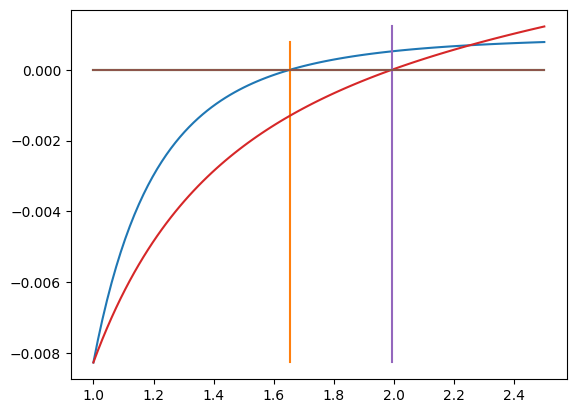

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

class auxiliary_class:
    def __init__(self):
        self.phi0 = 0.2
        self.entropic_unit = 136.6
        self.G = 0.13
        self.gamma = self.G/self.entropic_unit # 0.0009516837481698391 self.compute_gamma( lamb =1.4874):
        self.chi =  0.348# compute_chi(phi0=0.2035, gamma =0.0009516837481698391, J=J_iso)

    def phi(self, J):
        return self.phi0/J

    def H(self, J):
        return (J - self.phi0)*np.log(1-self.phi(J))  + self.phi0 * self.chi*(1-self.phi(J))

    def dH(self, J):
        return self.phi(J) + np.log(1-self.phi(J)) + self.chi * self.phi(J)**2

plotsH = auxiliary_class()

def auxFunctionEquibiaxial(s):
    return plotsH.dH(s*s) + plotsH.gamma

lambdaStar = scipy.optimize.fsolve(auxFunctionEquibiaxial, 2)
print(lambdaStar)

s = np.linspace(1,2.5,100) 
plt.plot(s,auxFunctionEquibiaxial(s))
plt.plot(lambdaStar+s*0, auxFunctionEquibiaxial(s))
plt.plot(s, s*0)

def auxFunctionUniaxial(s):
    return plotsH.dH(s) + plotsH.gamma*s

lambdaUniaxial = scipy.optimize.fsolve(auxFunctionUniaxial, 2)
print(lambdaUniaxial)

s = np.linspace(1,2.5,100) 
plt.plot(s,auxFunctionUniaxial(s))
plt.plot(lambdaUniaxial+s*0, auxFunctionUniaxial(s))
plt.plot(s, s*0)

In [10]:
class gel_bonded2D:
    def __init__(self):
        self.phi0 = 0.2
        self.entropic_unit = 136.6  # measured in MPa
        self.G = 0.13               # measured in MPa
        self.gamma = self.G/self.entropic_unit # 0.0009516837481698391 self.compute_gamma( lamb =1.4874):
        self.lambda_target = 1.99  # 0.13/136.3 = gammafun(1.99)
        self.chi =  0.348 # compute_chi(phi0=0.2035, gamma =0.0009516837481698391, J=J_iso)
        
        self.geometry_bonded()

    def geometry_bonded(self):
        self.L = 90      # measured in mm
        # self.d = 1.62    # measured in mm
        self.d = 3
        
        self.geo = geom2d.SplineGeometry()
        
        p1,p2,p3,p4 = [ self.geo.AddPoint (x,y) for x,y in [(-0.5*self.L,0), (0.5*self.L,0), \
                        (0.5*self.L,self.d), (-0.5*self.L,self.d)] ]
        self.geo.Append(["line",p1,p2],bc="bot")
        self.geo.Append(["line",p2,p3])
        self.geo.Append(["line",p3,p4])
        self.geo.Append(["line",p4,p1])

    def phi(self, J):
        return self.phi0/J

    def H(self, J):
        return (J - self.phi0)*log(1-self.phi(J))  + self.phi0 * self.chi*(1-self.phi(J))

    def dH(self, J):
        return self.phi(J) + np.log(1-self.phi(J)) + self.chi * self.phi(J)**2
    
    # compute gamma using uniaxial approximation
    def gammafun(self,lamb):
        return -self.dH(lamb)/lamb
        
    # energy density
    def W(self, F):
        J = Det(F)
        C = F.trans* F
        return 0.5*self.gamma * Trace(C) + self.H(J)
        #return 0.5*self.gamma * Trace(C) + (J-1)**2

class Solve_gel_bonded:
    def __init__(self, gel, maxh=5, corner_refinement=False):
        self.gel = gel
#        if corner_refinement:
#            mp = self.corner_refinement(maxh=maxh)
#            self.mesh = Mesh(gel.geo.GenerateMesh(mp=mp))
#        else:
#            self.mesh = Mesh(gel.geo.GenerateMesh(maxh=maxh))
        
        self.mesh = Mesh(gel.geo.GenerateMesh(maxh=maxh))
        # self.mesh.ngmesh.Save("simplified2D")

    def Space(self):
        # Finite element space with zero-displacement boundary condition on substrate
        self.fes = VectorH1(self.mesh, order=3, dirichlet="bot")

    def model(self):
        u  = self.fes.TrialFunction()
        I = Id(self.mesh.dim)
        F = I + Grad(u)
        # Ft = I+ Grad(u).Trace()

        # hydrogel model        
        self.a = BilinearForm(self.fes, symmetric=False)
        self.a += Variation(  self.gel.W(F).Compile() * dx)

    def Solve_incremental_softening(self):
        self.Space()
        self.gfu = GridFunction(self.fes)
        self.gfu.vec[:] = 0
        
        gamma_end = self.gel.gamma
        gamma0 = self.gel.gammafun(1.1)
        nIterations = 15
        self.gel.gamma = Parameter(gamma0)
        self.model()
        lambda_list = np.linspace(1.1, self.gel.lambda_target, nIterations, endpoint = False)
        gamma_list = [self.gel.gammafun(la) for la in lambda_list]
              
        filename="result_bonded2D_sub3_h1"

        self.w = GridFunction(self.fes); self.w.vec[:] = 0
        self.w0 = GridFunction(self.fes); self.w0.Set((x,y))   
        for numIteration in range(nIterations):
            gamma_i = gamma_list [numIteration]
            G_i = gamma_i*self.gel.entropic_unit
            lambda_uni_i = lambda_list[numIteration]
            print("*** Iteration #", numIteration, ". Shear modulus G = ", G_i, \
                  ". expected max Y_displacement= ", (lambda_uni_i-1)*self.gel.d)
            
            self.gel.gamma.Set(gamma_i)
            self.gfu, _,_ = SolveNonlinearMinProblem(a= self.a, gfu = self.gfu,\
                        FreeDofs =self.fes.FreeDofs(), maxits=100, tol=1e-03)
            
            Draw(self.gfu, deformation=True)            
            # vtk.Do() # Exports the results:
            self.gfu.Save(filename + "_{}.gfu".format(numIteration))

            numIteration +=1 
            self.w = self.w0 + self.gfu
            print("Deformed point on the middle of the top surface: ", self.w(self.mesh(0,self.gel.d)))  

        # final
        print("*** Final gamma = ", gamma_end)
        
        self.gel.gamma.Set(gamma_end) 
        self.gfu, _,_ = SolveNonlinearMinProblem(a= self.a, gfu = self.gfu,\
                            FreeDofs =self.fes.FreeDofs(), maxits=500, tol=1e-06)
        self.w = self.w0 + self.gfu
        print("Deformed point on the middle of the top surface: ", self.w(self.mesh(0,self.gel.d)))  
        
        Draw(self.gfu, deformation=True)
        # vtk.Do() # Exports the results
        self.gfu.Save(filename + "_{}.gfu".format(numIteration))

def SolveNonlinearMinProblem(a, gfu, FreeDofs, tol=1e-08, maxits=50):#, scenes=None):
    res = gfu.vec.CreateVector()
    du  = gfu.vec.CreateVector()

    for it in range(maxits):
        print ("Newton iteration {:3}".format(it),end=", ")
        print ("energy = {:16}".format(a.Energy(gfu.vec)),end="")
        #solve linearized problem:
        a.Apply (gfu.vec, res)
        a.AssembleLinearization (gfu.vec)
        inv = a.mat.Inverse(FreeDofs)
        alpha = 5e-2
        du.data = alpha * inv * res

        #update iteration
        gfu.vec.data -= du

        #stopping criteria
        stopcritval = sqrt(abs(InnerProduct(du,res)))
        print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
        if stopcritval < tol:
            break
        #for sc in scenes:
        #    sc.Redraw()
    return gfu, stopcritval, it
        

In [11]:
GEL = gel_bonded2D()
modelling = Solve_gel_bonded ( GEL, maxh=0.9, corner_refinement = False)
modelling.Solve_incremental_softening()

*** Iteration # 0 . Shear modulus G =  0.9125353645057322 . expected max Y_displacement=  0.30000000000000027
Newton iteration   0, energy = -31.36171346442144<A u 0 , A u 0 >_{-1}^0.5 =  0.056074175786459575
Newton iteration   1, energy = -31.364779343701326<A u 1 , A u 1 >_{-1}^0.5 =  0.053500177684656876
Newton iteration   2, energy = -31.367570283554322<A u 2 , A u 2 >_{-1}^0.5 =  0.051088686696322064
Newton iteration   3, energy = -31.370115298554552<A u 3 , A u 3 >_{-1}^0.5 =  0.048787169633219676
Newton iteration   4, energy = -31.3724361715813<A u 4 , A u 4 >_{-1}^0.5 =  0.04658317879533458
Newton iteration   5, energy = -31.374552081569046<A u 5 , A u 5 >_{-1}^0.5 =  0.04447076121804063
Newton iteration   6, energy = -31.376480435457<A u 6 , A u 6 >_{-1}^0.5 =  0.042445862833192426
Newton iteration   7, energy = -31.37823717334987<A u 7 , A u 7 >_{-1}^0.5 =  0.040505143555091924
Newton iteration   8, energy = -31.37983693477336<A u 8 , A u 8 >_{-1}^0.5 =  0.03864558502039271
N

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (5.572399510729882e-09, 3.2949214095392896)
*** Iteration # 1 . Shear modulus G =  0.7649451396071408 . expected max Y_displacement=  0.478
Newton iteration   0, energy = -31.718290158050127<A u 0 , A u 0 >_{-1}^0.5 =  0.031180776168677107
Newton iteration   1, energy = -31.719238142307386<A u 1 , A u 1 >_{-1}^0.5 =  0.029717390664897887
Newton iteration   2, energy = -31.720099230647715<A u 2 , A u 2 >_{-1}^0.5 =  0.028318927591816145
Newton iteration   3, energy = -31.720881180766142<A u 3 , A u 3 >_{-1}^0.5 =  0.026982719219186053
Newton iteration   4, energy = -31.721591078790738<A u 4 , A u 4 >_{-1}^0.5 =  0.025706232010505405
Newton iteration   5, energy = -31.722235397143123<A u 5 , A u 5 >_{-1}^0.5 =  0.024487042296090358
Newton iteration   6, energy = -31.722820046478663<A u 6 , A u 6 >_{-1}^0.5 =  0.023322821140387837
Newton iteration   7, energy = -31.723350422805026<A u 7 , A u 7 >_{-1}^0.5 =  0.022211324674194836
Newton ite

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (1.8791373376694622e-08, 3.4725868347375566)
*** Iteration # 2 . Shear modulus G =  0.6474521985002586 . expected max Y_displacement=  0.6560000000000004
Newton iteration   0, energy = -32.00128568887063<A u 0 , A u 0 >_{-1}^0.5 =  0.028670719132718476
Newton iteration   1, energy = -32.00208718781029<A u 1 , A u 1 >_{-1}^0.5 =  0.027319300851046165
Newton iteration   2, energy = -32.002814907427705<A u 2 , A u 2 >_{-1}^0.5 =  0.02602836245612962
Newton iteration   3, energy = -32.00347547577208<A u 3 , A u 3 >_{-1}^0.5 =  0.024795383179278183
Newton iteration   4, energy = -32.00407494220855<A u 4 , A u 4 >_{-1}^0.5 =  0.02361796537544613
Newton iteration   5, energy = -32.004618827563625<A u 5 , A u 5 >_{-1}^0.5 =  0.022493815107100204
Newton iteration   6, energy = -32.00511216928495<A u 6 , A u 6 >_{-1}^0.5 =  0.021420729605328384
Newton iteration   7, energy = -32.00555956245275<A u 7 , A u 7 >_{-1}^0.5 =  0.020396588932945815
Newt

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (5.1317111400437706e-08, 3.650015632308158)
*** Iteration # 3 . Shear modulus G =  0.5527762033333189 . expected max Y_displacement=  0.8340000000000001
Newton iteration   0, energy = -32.24321875418165<A u 0 , A u 0 >_{-1}^0.5 =  0.026515991319973013
Newton iteration   1, energy = -32.24390430584991<A u 1 , A u 1 >_{-1}^0.5 =  0.025261383844272078
Newton iteration   2, energy = -32.24452651719879<A u 2 , A u 2 >_{-1}^0.5 =  0.02406335365210406
Newton iteration   3, energy = -32.24509110977178<A u 3 , A u 3 >_{-1}^0.5 =  0.0229195123833073
Newton iteration   4, energy = -32.24560330179924<A u 4 , A u 4 >_{-1}^0.5 =  0.021827586150078685
Newton iteration   5, energy = -32.24606785207305<A u 5 , A u 5 >_{-1}^0.5 =  0.020785399556212784
Newton iteration   6, energy = -32.24648909954384<A u 6 , A u 6 >_{-1}^0.5 =  0.01979086502681384
Newton iteration   7, energy = -32.24687099930137<A u 7 , A u 7 >_{-1}^0.5 =  0.018841975459401677
Newton it

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (1.218480596837609e-07, 3.8277025339413164)
*** Iteration # 4 . Shear modulus G =  0.4756482758891544 . expected max Y_displacement=  1.0120000000000005
Newton iteration   0, energy = -32.452215406665275<A u 0 , A u 0 >_{-1}^0.5 =  0.024589677618945437
Newton iteration   1, energy = -32.45280496783688<A u 1 , A u 1 >_{-1}^0.5 =  0.02342204725118166
Newton iteration   2, energy = -32.45333986729768<A u 2 , A u 2 >_{-1}^0.5 =  0.022307455620658834
Newton iteration   3, energy = -32.45382506840736<A u 3 , A u 3 >_{-1}^0.5 =  0.02124363470279875
Newton iteration   4, energy = -32.45426509469956<A u 4 , A u 4 >_{-1}^0.5 =  0.020228424264271138
Newton iteration   5, energy = -32.454664068491745<A u 5 , A u 5 >_{-1}^0.5 =  0.01925975832830587
Newton iteration   6, energy = -32.45502574577441<A u 6 , A u 6 >_{-1}^0.5 =  0.01833565584944396
Newton iteration   7, energy = -32.455353547916864<A u 7 , A u 7 >_{-1}^0.5 =  0.0174542140778253
Newton i

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (2.595438425197243e-07, 4.005032584649653)
*** Iteration # 5 . Shear modulus G =  0.41219224572544255 . expected max Y_displacement=  1.1900000000000002
Newton iteration   0, energy = -32.6343756430078<A u 0 , A u 0 >_{-1}^0.5 =  0.02293217145811719
Newton iteration   1, energy = -32.63488840098633<A u 1 , A u 1 >_{-1}^0.5 =  0.021839724657781025
Newton iteration   2, energy = -32.63535346816284<A u 2 , A u 2 >_{-1}^0.5 =  0.02079723801201197
Newton iteration   3, energy = -32.63577519574322<A u 3 , A u 3 >_{-1}^0.5 =  0.0198025467038344
Newton iteration   4, energy = -32.63615754662051<A u 4 , A u 4 >_{-1}^0.5 =  0.018853589203981953
Newton iteration   5, energy = -32.63650412974431<A u 5 , A u 5 >_{-1}^0.5 =  0.01794839528675651
Newton iteration   6, energy = -32.63681823118875<A u 6 , A u 6 >_{-1}^0.5 =  0.017085077540222548
Newton iteration   7, energy = -32.63710284237212<A u 7 , A u 7 >_{-1}^0.5 =  0.016261825151528103
Newton iter

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (5.040071305273118e-07, 4.1826578750893315)
*** Iteration # 6 . Shear modulus G =  0.3595139752662779 . expected max Y_displacement=  1.3679999999999999
Newton iteration   0, energy = -32.7944843365447<A u 0 , A u 0 >_{-1}^0.5 =  0.02142381690600095
Newton iteration   1, energy = -32.794931858833515<A u 1 , A u 1 >_{-1}^0.5 =  0.020400068813453846
Newton iteration   2, energy = -32.79533763225777<A u 2 , A u 2 >_{-1}^0.5 =  0.019423450928758534
Newton iteration   3, energy = -32.79570548371688<A u 3 , A u 3 >_{-1}^0.5 =  0.018491892491235104
Newton iteration   4, energy = -32.796038896147344<A u 4 , A u 4 >_{-1}^0.5 =  0.01760342269677909
Newton iteration   5, energy = -32.796341039250244<A u 5 , A u 5 >_{-1}^0.5 =  0.016756159813537484
Newton iteration   6, energy = -32.796614797260176<A u 6 , A u 6 >_{-1}^0.5 =  0.015948303258815816
Newton iteration   7, energy = -32.796862794149035<A u 7 , A u 7 >_{-1}^0.5 =  0.01517812764217256
Newt

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (8.990501303899915e-07, 4.359867910303764)
*** Iteration # 7 . Shear modulus G =  0.3154233051888026 . expected max Y_displacement=  1.5460000000000003
Newton iteration   0, energy = -32.936212239793306<A u 0 , A u 0 >_{-1}^0.5 =  0.020120289596250562
Newton iteration   1, energy = -32.93660695918074<A u 1 , A u 1 >_{-1}^0.5 =  0.019156201833380355
Newton iteration   2, energy = -32.93696475744376<A u 2 , A u 2 >_{-1}^0.5 =  0.018236770364945434
Newton iteration   3, energy = -32.93728903335839<A u 3 , A u 3 >_{-1}^0.5 =  0.017360004932719136
Newton iteration   4, energy = -32.937582878112096<A u 4 , A u 4 >_{-1}^0.5 =  0.01652401352441654
Newton iteration   5, energy = -32.9378491030684<A u 5 , A u 5 >_{-1}^0.5 =  0.015726992011098243
Newton iteration   6, energy = -32.9380902648334<A u 6 , A u 6 >_{-1}^0.5 =  0.014967216426347416
Newton iteration   7, energy = -32.938308687977084<A u 7 , A u 7 >_{-1}^0.5 =  0.014243037036242686
Newton

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (1.4873705197990289e-06, 4.537418604462147)
*** Iteration # 8 . Shear modulus G =  0.27824236160063337 . expected max Y_displacement=  1.724
Newton iteration   0, energy = -33.062535097908565<A u 0 , A u 0 >_{-1}^0.5 =  0.0189138889284344
Newton iteration   1, energy = -33.06288390135842<A u 1 , A u 1 >_{-1}^0.5 =  0.01800531479552301
Newton iteration   2, energy = -33.063199998092244<A u 2 , A u 2 >_{-1}^0.5 =  0.017139064881822024
Newton iteration   3, energy = -33.063486410797424<A u 3 , A u 3 >_{-1}^0.5 =  0.01631322717712278
Newton iteration   4, energy = -33.06374588684045<A u 4 , A u 4 >_{-1}^0.5 =  0.015525986416097518
Newton iteration   5, energy = -33.06398092337332<A u 5 , A u 5 >_{-1}^0.5 =  0.014775614018093065
Newton iteration   6, energy = -33.06419378997331<A u 6 , A u 6 >_{-1}^0.5 =  0.014060460450533538
Newton iteration   7, energy = -33.06438654913395<A u 7 , A u 7 >_{-1}^0.5 =  0.013378949269771446
Newton iteration  

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (2.3046929817238117e-06, 4.714958595578079)
*** Iteration # 9 . Shear modulus G =  0.2466712091017882 . expected max Y_displacement=  1.9019999999999997
Newton iteration   0, energy = -33.175789453491085<A u 0 , A u 0 >_{-1}^0.5 =  0.01782660116441655
Newton iteration   1, energy = -33.176099306270615<A u 1 , A u 1 >_{-1}^0.5 =  0.016968330241561375
Newton iteration   2, energy = -33.17638004092711<A u 2 , A u 2 >_{-1}^0.5 =  0.01615023964710168
Newton iteration   3, energy = -33.17663435785025<A u 3 , A u 3 >_{-1}^0.5 =  0.015370492724676024
Newton iteration   4, energy = -33.17686471007022<A u 4 , A u 4 >_{-1}^0.5 =  0.014627347882498223
Newton iteration   5, energy = -33.17707332602053<A u 5 , A u 5 >_{-1}^0.5 =  0.013919148733442717
Newton iteration   6, energy = -33.1772622300386<A u 6 , A u 6 >_{-1}^0.5 =  0.013244316516392459
Newton iteration   7, energy = -33.17743326089523<A u 7 , A u 7 >_{-1}^0.5 =  0.012601344122407335
Newton

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (3.378813555544373e-06, 4.89197119574412)
*** Iteration # 10 . Shear modulus G =  0.21969226614433846 . expected max Y_displacement=  2.08
Newton iteration   0, energy = -33.2778658186343<A u 0 , A u 0 >_{-1}^0.5 =  0.0168893655742822
Newton iteration   1, energy = -33.27814394636023<A u 1 , A u 1 >_{-1}^0.5 =  0.016074654581059628
Newton iteration   2, energy = -33.278395888296934<A u 2 , A u 2 >_{-1}^0.5 =  0.01529824647291599
Newton iteration   3, energy = -33.27862408008606<A u 3 , A u 3 >_{-1}^0.5 =  0.014558372725782295
Newton iteration   4, energy = -33.2788307331802<A u 4 , A u 4 >_{-1}^0.5 =  0.013853358239893383
Newton iteration   5, energy = -33.279017855637804<A u 5 , A u 5 >_{-1}^0.5 =  0.013181611599025546
Newton iteration   6, energy = -33.279187270828345<A u 6 , A u 6 >_{-1}^0.5 =  0.012541617526701982
Newton iteration   7, energy = -33.279340634318494<A u 7 , A u 7 >_{-1}^0.5 =  0.011931930904916154
Newton iteration   8

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (4.729895716303907e-06, 5.069394496159465)
*** Iteration # 11 . Shear modulus G =  0.19650135189491527 . expected max Y_displacement=  2.2580000000000005
Newton iteration   0, energy = -33.37035462878146<A u 0 , A u 0 >_{-1}^0.5 =  0.01600209780620642
Newton iteration   1, energy = -33.37060430133133<A u 1 , A u 1 >_{-1}^0.5 =  0.015228770048071591
Newton iteration   2, energy = -33.370830425092414<A u 2 , A u 2 >_{-1}^0.5 =  0.014491940992772366
Newton iteration   3, energy =  -33.37103519646<A u 3 , A u 3 >_{-1}^0.5 =  0.013789911020486354
Newton iteration   4, energy = -33.37122060879051<A u 4 , A u 4 >_{-1}^0.5 =  0.01312107161205894
Newton iteration   5, energy = -33.37138847135919<A u 5 , A u 5 >_{-1}^0.5 =  0.01248389586682831
Newton iteration   6, energy = -33.37154042639549<A u 6 , A u 6 >_{-1}^0.5 =  0.01187693110962304
Newton iteration   7, energy = -33.371677964449894<A u 7 , A u 7 >_{-1}^0.5 =  0.011298792996920394
Newton i

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (6.342229057960946e-06, 5.246805971997389)
*** Iteration # 12 . Shear modulus G =  0.1764573065213608 . expected max Y_displacement=  2.436
Newton iteration   0, energy = -33.45452673694282<A u 0 , A u 0 >_{-1}^0.5 =  0.015194403090199508
Newton iteration   1, energy = -33.45475184116241<A u 1 , A u 1 >_{-1}^0.5 =  0.014458865273703787
Newton iteration   2, energy = -33.45495567880512<A u 2 , A u 2 >_{-1}^0.5 =  0.01375816391188908
Newton iteration   3, energy = -33.45514023835741<A u 3 , A u 3 >_{-1}^0.5 =  0.01309066486269185
Newton iteration   4, energy = -33.45530732378487<A u 4 , A u 4 >_{-1}^0.5 =  0.012454822600612645
Newton iteration   5, energy = -33.45545857185818<A u 5 , A u 5 >_{-1}^0.5 =  0.011849171016504186
Newton iteration   6, energy = -33.45559546771039<A u 6 , A u 6 >_{-1}^0.5 =  0.011272316204963264
Newton iteration   7, energy = -33.455719358859504<A u 7 , A u 7 >_{-1}^0.5 =  0.010722930688392097
Newton iteration   

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (8.104409466473803e-06, 5.424179277087218)
*** Iteration # 13 . Shear modulus G =  0.15904474545323 . expected max Y_displacement=  2.614
Newton iteration   0, energy = -33.53145115576401<A u 0 , A u 0 >_{-1}^0.5 =  0.014460346561744025
Newton iteration   1, energy = -33.53165503509459<A u 1 , A u 1 >_{-1}^0.5 =  0.013759265557072504
Newton iteration   2, energy = -33.5318396241482<A u 2 , A u 2 >_{-1}^0.5 =  0.0130914876294771
Newton iteration   3, energy = -33.5320067305406<A u 3 , A u 3 >_{-1}^0.5 =  0.01245544148657766
Newton iteration   4, energy = -33.532157993618604<A u 4 , A u 4 >_{-1}^0.5 =  0.011849641799771804
Newton iteration   5, energy = -33.532294900330875<A u 5 , A u 5 >_{-1}^0.5 =  0.011272680292491144
Newton iteration   6, energy = -33.532418799471<A u 6 , A u 6 >_{-1}^0.5 =  0.010723218724715976
Newton iteration   7, energy = -33.53253091450718<A u 7 , A u 7 >_{-1}^0.5 =  0.010199983256651255
Newton iteration   8, ene

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (9.504515028480202e-06, 5.601509652925831)
*** Iteration # 14 . Shear modulus G =  0.1438462208844834 . expected max Y_displacement=  2.7920000000000003
Newton iteration   0, energy = -33.602025723940116<A u 0 , A u 0 >_{-1}^0.5 =  0.013801439680684858
Newton iteration   1, energy = -33.602211446333754<A u 1 , A u 1 >_{-1}^0.5 =  0.01313178570103013
Newton iteration   2, energy = -33.60237958310331<A u 2 , A u 2 >_{-1}^0.5 =  0.012493957993617476
Newton iteration   3, energy = -33.602531783163876<A u 3 , A u 3 >_{-1}^0.5 =  0.011886447978570629
Newton iteration   4, energy = -33.60266954170522<A u 4 , A u 4 >_{-1}^0.5 =  0.011307831376599894
Newton iteration   5, energy = -33.6027942147582<A u 5 , A u 5 >_{-1}^0.5 =  0.01075675951363159
Newton iteration   6, energy = -33.60290703225641<A u 6 , A u 6 >_{-1}^0.5 =  0.010231952380741543
Newton iteration   7, energy = -33.60300910979013<A u 7 , A u 7 >_{-1}^0.5 =  0.00973219297096026
Newton

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Deformed point on the middle of the top surface:  (5.980825361497087e-06, 5.77879274220432)
*** Final gamma =  0.0009516837481698391
Newton iteration   0, energy = -33.66948615004703<A u 0 , A u 0 >_{-1}^0.5 =  0.013077303097579275
Newton iteration   1, energy = -33.66965084440403<A u 1 , A u 1 >_{-1}^0.5 =  0.013051746070317326
Newton iteration   2, energy = -33.66981693910028<A u 2 , A u 2 >_{-1}^0.5 =  0.012424463680602776
Newton iteration   3, energy = -33.66996745211052<A u 3 , A u 3 >_{-1}^0.5 =  0.011827783014785662
Newton iteration   4, energy = -33.67010385565903<A u 4 , A u 4 >_{-1}^0.5 =  0.011260257978348108
Newton iteration   5, energy = -33.67022748339266<A u 5 , A u 5 >_{-1}^0.5 =  0.010720509042513853
Newton iteration   6, energy = -33.67033954331435<A u 6 , A u 6 >_{-1}^0.5 =  0.01020721091403872
Newton iteration   7, energy = -33.67044112933613<A u 7 , A u 7 >_{-1}^0.5 =  0.00971908313703918
Newton iteration   8, energy = -33.67053323166877<A u 8 , A u 8 >_{-1}^0.5 = 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [5]:
#Draw(modelling.mesh)
#Draw(Id(2)+Grad(modelling.gfu), modelling.mesh)
L= 90
d =3
p1,p2,p3,p4 = [ (x,y) for x,y in [(-0.5*L,0), (0.5*L,0), \
                        (0.5*L,d), (-0.5*L,d)] ]
print("p1 = ", p1)
print("p2 = ", p2)
print("p3 = ", p3)
print("p4 = ", p4)

print((modelling.gfu[1]+y)(modelling.mesh(0, 3)))

filename="result_bonded2D_sub3_h1"
print(filename)
Draw(modelling.gfu[1]+y, modelling.mesh, deformation=modelling.gfu)
# vtk = VTKOutput(ma=modelling.mesh, coefs=[modelling.gfu], names = ["displacement"], filename=filename, subdivision=3)   
# vtk.Do()

p1 =  (-45.0, 0)
p2 =  (45.0, 0)
p3 =  (45.0, 5)
p4 =  (-45.0, 5)
3.2278128872307104
result_bonded2D_sub3_h1


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

'result_bonded2D_sub3_h1'